In [1]:
# Install required packages if not already installed
!pip install pandas matplotlib pillow opencv-python scikit-learn -q


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Install TensorFlow (use CPU version for compatibility)
!pip install tensorflow-cpu -q

# Also install other required packages to be sure
!pip install pandas matplotlib pillow opencv-python scikit-learn -q

print("✅ All packages installed successfully!")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ All packages installed successfully!



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
# Import fundamental libraries
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import cv2
from sklearn.model_selection import train_test_split
import shutil
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Configure display settings
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

print("📚 Essential libraries imported:")
print(f"Python: {sys.version[:6]}")
print(f"Pandas: {pd.__version__}")
print(f"OpenCV: {cv2.__version__}")

📚 Essential libraries imported:
Python: 3.11.9
Pandas: 2.3.3
OpenCV: 4.12.0


In [13]:
# Configure project workspace
PROJECT_ROOT = Path.cwd()
print(f"📍 Project Location: {PROJECT_ROOT}")

# Define dataset location - UPDATE THIS!
SKIN_DATA_FOLDER = Path(r"C:\Users\user\Downloads\new infosys project\DATASET")

# Verify dataset existence
if SKIN_DATA_FOLDER.exists():
    print(f"✅ Dataset located at: {SKIN_DATA_FOLDER}")
    folder_items = list(SKIN_DATA_FOLDER.iterdir())
    print(f"📁 Contains {len(folder_items)} items")
else:
    print("⚠️ Dataset folder not found!")
    print("\nSearching for potential dataset folders...")
    for item in PROJECT_ROOT.iterdir():
        if item.is_dir() and any(keyword in item.name.lower() 
                                 for keyword in ['data', 'skin', 'derm', 'image']):
            print(f"   Found: {item.name}")

📍 Project Location: c:\Users\user\Downloads\new infosys project
✅ Dataset located at: C:\Users\user\Downloads\new infosys project\DATASET
📁 Contains 4 items


In [14]:
# Analyze dataset organization
print("🔍 Scanning dataset structure...")
print("=" * 50)

category_folders = []
for item in SKIN_DATA_FOLDER.iterdir():
    if item.is_dir():
        category_folders.append(item)
        print(f"📂 Category folder: {item.name}")

print(f"\nTotal category folders found: {len(category_folders)}")

🔍 Scanning dataset structure...
📂 Category folder: clear skin
📂 Category folder: dark spots
📂 Category folder: puffy eyes
📂 Category folder: wrinkles

Total category folders found: 4


In [15]:
# Tally images per category
skin_categories = []
image_tallies = []

VALID_IMAGE_TYPES = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

for category in category_folders:
    image_files = [f for f in category.iterdir() 
                   if f.suffix.lower() in VALID_IMAGE_TYPES]
    
    skin_categories.append(category.name)
    image_tallies.append(len(image_files))
    
    print(f"📊 {category.name}: {len(image_files)} images")

# Compile statistics
image_stats = pd.DataFrame({
    'Skin_Condition': skin_categories,
    'Image_Count': image_tallies
})

print(f"\n📈 Total images across all categories: {sum(image_tallies)}")

📊 clear skin: 300 images
📊 dark spots: 303 images
📊 puffy eyes: 300 images
📊 wrinkles: 300 images

📈 Total images across all categories: 1203


In [16]:
# Present organized statistics
print("📋 Dataset Composition Summary")
print("=" * 50)
print(image_stats.to_string(index=False))

# Calculate percentages
image_stats['Percentage'] = (image_stats['Image_Count'] / image_stats['Image_Count'].sum() * 100).round(2)
print("\n📊 Percentage Distribution:")
for _, row in image_stats.iterrows():
    print(f"   {row['Skin_Condition']}: {row['Percentage']}%")

📋 Dataset Composition Summary
Skin_Condition  Image_Count
    clear skin          300
    dark spots          303
    puffy eyes          300
      wrinkles          300

📊 Percentage Distribution:
   clear skin: 24.94%
   dark spots: 25.19%
   puffy eyes: 24.94%
   wrinkles: 24.94%


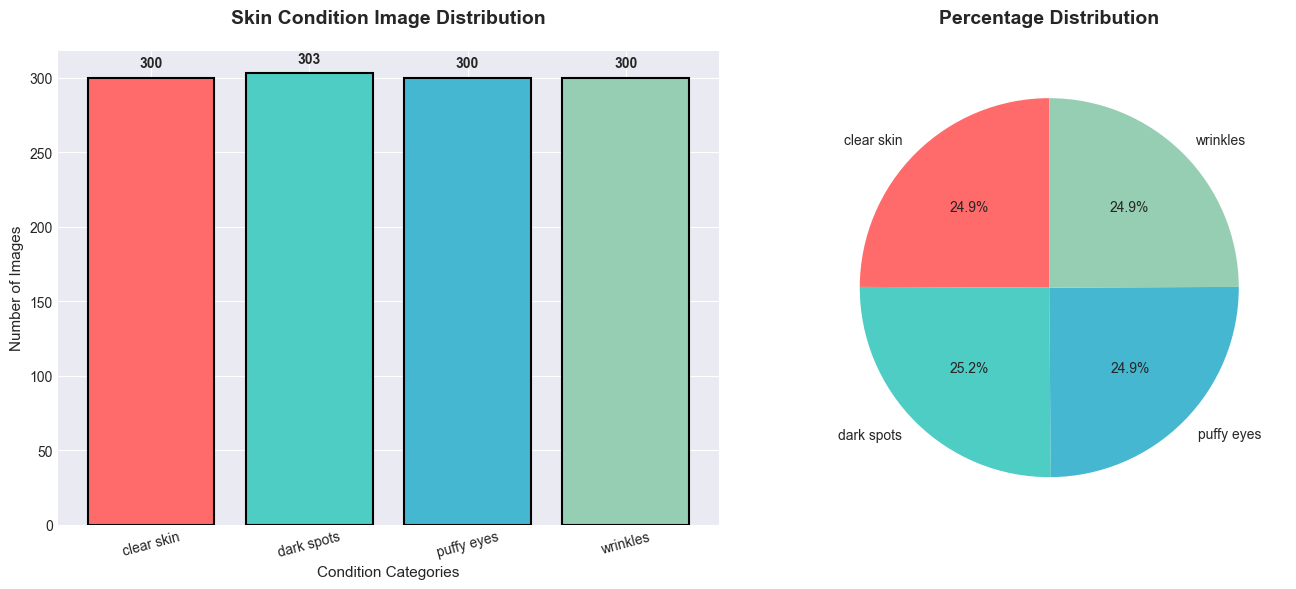

📊 Visualization complete - Total images: 1203


In [17]:
# Create custom visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
bars = ax1.bar(image_stats['Skin_Condition'], image_stats['Image_Count'], 
               color=colors, edgecolor='black', linewidth=1.5)

ax1.set_title('Skin Condition Image Distribution', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Condition Categories', fontsize=11)
ax1.set_ylabel('Number of Images', fontsize=11)
ax1.tick_params(axis='x', rotation=15)

# Add value labels
for rect, count in zip(bars, image_stats['Image_Count']):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width()/2., height + 5,
             f'{count}', ha='center', va='bottom', fontweight='bold')

# Pie chart
wedges, texts, autotexts = ax2.pie(image_stats['Image_Count'], 
                                   labels=image_stats['Skin_Condition'],
                                   colors=colors, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 10})
ax2.set_title('Percentage Distribution', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print(f"📊 Visualization complete - Total images: {image_stats['Image_Count'].sum()}")

In [18]:
def prepare_skin_image(image_path, dimensions=(224, 224)):
    """
    Standardize skin image for analysis
    
    Parameters:
        image_path: Path to skin image
        dimensions: Target size (width, height)
    
    Returns:
        Processed image array
    """
    try:
        # Load image
        skin_img = cv2.imread(str(image_path))
        if skin_img is None:
            raise ValueError(f"Unable to read: {image_path}")
        
        # Convert color space
        skin_img = cv2.cvtColor(skin_img, cv2.COLOR_BGR2RGB)
        
        # Resize uniformly
        skin_img = cv2.resize(skin_img, dimensions)
        
        # Normalize pixel values
        skin_img = skin_img.astype("float32") / 255.0
        
        return skin_img
        
    except Exception as processing_error:
        print(f"Processing failed for {image_path}: {processing_error}")
        return None

In [19]:
# Test processing on sample images
print("🧪 Testing image processing pipeline...")
print("=" * 50)

sample_images_collected = []
for category in category_folders[:2]:  # Test first two categories
    image_files = [f for f in category.iterdir() 
                   if f.suffix.lower() in VALID_IMAGE_TYPES]
    
    if image_files:
        test_image = image_files[0]
        processed = prepare_skin_image(test_image)
        
        if processed is not None:
            sample_images_collected.append((test_image, processed))
            print(f"✓ Processed: {test_image.name}")
            print(f"  Shape: {processed.shape}, Range: [{processed.min():.3f}, {processed.max():.3f}]")
        else:
            print(f"✗ Failed: {test_image.name}")

print(f"\n✅ Successfully processed {len(sample_images_collected)} test images")

🧪 Testing image processing pipeline...
✓ Processed: clear_skin_001.jpg
  Shape: (224, 224, 3), Range: [0.000, 0.996]
✓ Processed: 0183c6d6-8b71-4a85-a2c3-fe3fcbca3668.jpg
  Shape: (224, 224, 3), Range: [0.000, 1.000]

✅ Successfully processed 2 test images


Sample 1: Min=0.000, Max=0.996, Mean=0.330
Sample 2: Min=0.000, Max=1.000, Mean=0.477


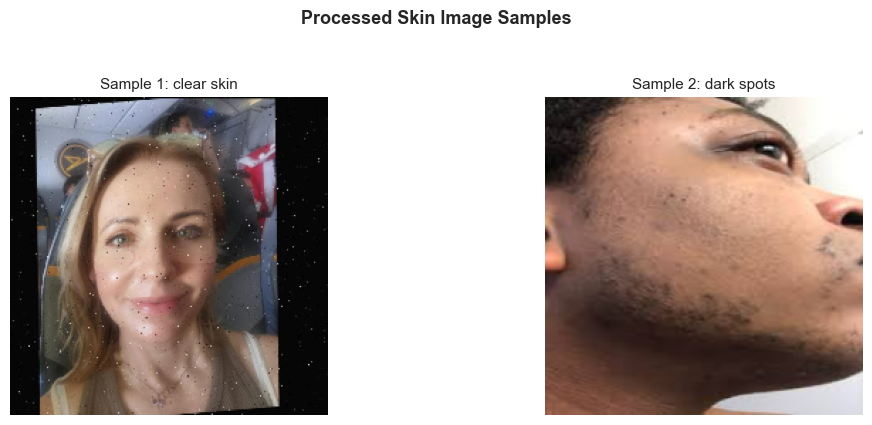

In [20]:
# Show processed results
if sample_images_collected:
    fig, axes = plt.subplots(1, len(sample_images_collected), figsize=(12, 4))
    
    if len(sample_images_collected) == 1:
        axes = [axes]
    
    for idx, (img_path, processed_img) in enumerate(sample_images_collected):
        axes[idx].imshow(processed_img)
        axes[idx].set_title(f"Sample {idx+1}: {img_path.parent.name}", fontsize=11)
        axes[idx].axis('off')
        
        # Display pixel info
        print(f"Sample {idx+1}: Min={processed_img.min():.3f}, "
              f"Max={processed_img.max():.3f}, "
              f"Mean={processed_img.mean():.3f}")
    
    plt.suptitle('Processed Skin Image Samples', fontsize=13, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()
else:
    print("No sample images available for display")

In [22]:
print("🔄 Configuring data augmentation...")

try:
    import tensorflow as tf
    print(f"TensorFlow {tf.__version__} detected - using advanced augmentation")
    
    # Different TensorFlow versions have different layer names
    # Let's check what's available
    if hasattr(tf.keras.layers, 'RandomFlip'):
        # For newer TensorFlow versions
        augmentation_pipeline = tf.keras.Sequential([
            tf.keras.layers.RandomFlip(mode="horizontal"),
            tf.keras.layers.RandomRotation(factor=0.08),
            tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
            tf.keras.layers.RandomBrightness(factor=0.15)
        ])
    else:
        # For older versions
        augmentation_pipeline = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.08),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
            tf.keras.layers.experimental.preprocessing.RandomContrast(0.2)
        ])
    
    print("✅ Augmentation pipeline ready")
    TF_AVAILABLE = True
    
except ImportError:
    print("TensorFlow not available - using basic augmentation")
    
    def simple_augment_image(img_array):
        """Basic augmentation using NumPy/OpenCV"""
        import random
        augmented = img_array.copy()
        
        # Horizontal flip
        if random.random() > 0.5:
            augmented = np.fliplr(augmented)
        
        # Brightness adjustment
        brightness_factor = random.uniform(0.9, 1.1)
        augmented = np.clip(augmented * brightness_factor, 0, 1)
        
        return augmented
    
    print("✅ Basic augmentation functions ready")
    TF_AVAILABLE = False
except AttributeError as e:
    print(f"TensorFlow layer issue: {e}")
    print("Falling back to basic augmentation")
    
    def simple_augment_image(img_array):
        """Basic augmentation using NumPy/OpenCV"""
        import random
        augmented = img_array.copy()
        
        # Horizontal flip
        if random.random() > 0.5:
            augmented = np.fliplr(augmented)
        
        # Brightness adjustment
        brightness_factor = random.uniform(0.9, 1.1)
        augmented = np.clip(augmented * brightness_factor, 0, 1)
        
        return augmented
    
    print("✅ Basic augmentation functions ready")
    TF_AVAILABLE = False

🔄 Configuring data augmentation...
TensorFlow 2.20.0 detected - using advanced augmentation
✅ Augmentation pipeline ready


In [23]:
def generate_augmented_versions(image_path, augmentation_count=3):
    """
    Create augmented variations of an image
    
    Parameters:
        image_path: Source image path
        augmentation_count: Number of variations to create
    
    Returns:
        Original image and list of augmented versions
    """
    original_img = prepare_skin_image(image_path)
    if original_img is None:
        return None, []
    
    augmented_collection = []
    
    if TF_AVAILABLE:
        # TensorFlow augmentation
        batch_img = tf.expand_dims(original_img, 0)
        for _ in range(augmentation_count):
            augmented = augmentation_pipeline(batch_img, training=True)
            augmented_collection.append(tf.squeeze(augmented).numpy())
    else:
        # Basic augmentation
        for _ in range(augmentation_count):
            augmented = simple_augment_image(original_img)
            augmented_collection.append(augmented)
    
    return original_img, augmented_collection

In [24]:
def visualize_augmentation_examples(image_paths_list, variations=3):
    """
    Display original and augmented images side by side
    """
    for img_idx, img_path in enumerate(image_paths_list):
        print(f"\nProcessing image {img_idx+1}/{len(image_paths_list)}: {Path(img_path).name}")
        
        original, augmented_set = generate_augmented_versions(img_path, variations)
        
        if original is None:
            continue
            
        # Create visualization
        fig, axes = plt.subplots(1, variations + 1, figsize=(3 * (variations + 1), 3))
        
        # Display original
        axes[0].imshow(original)
        axes[0].set_title("Original", fontsize=10)
        axes[0].axis('off')
        
        # Display augmentations
        for aug_idx, aug_img in enumerate(augmented_set):
            axes[aug_idx + 1].imshow(aug_img)
            axes[aug_idx + 1].set_title(f"Aug {aug_idx + 1}", fontsize=10)
            axes[aug_idx + 1].axis('off')
        
        plt.suptitle(f"Augmentation Examples", fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()

Testing augmentation on 2 sample images...

Processing image 1/2: clear_skin_001.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7.66985..8.641452].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [15.578004..16.554852].


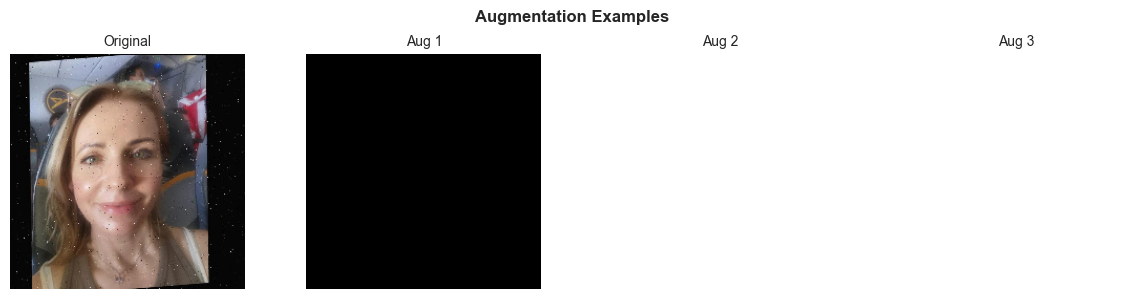

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [10.116703..11.116702].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [34.025818..35.02557].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [7.2217627..8.221668].



Processing image 2/2: 0183c6d6-8b71-4a85-a2c3-fe3fcbca3668.jpg


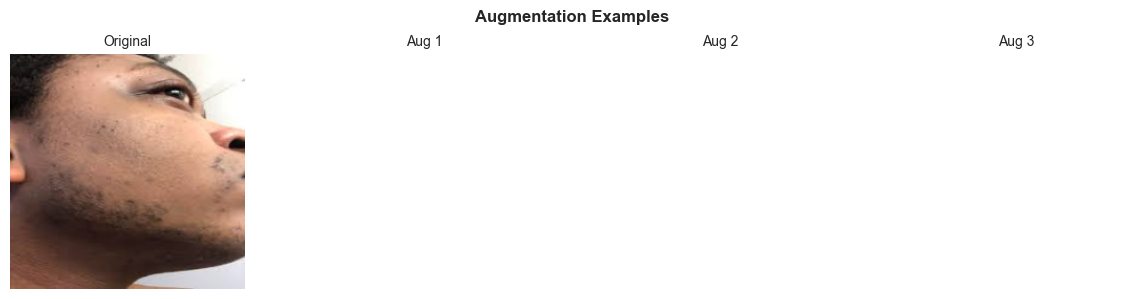

In [25]:
# Collect sample images for augmentation testing
test_samples = []
for category in category_folders[:2]:  # Use first two categories
    image_files = [f for f in category.iterdir() 
                   if f.suffix.lower() in VALID_IMAGE_TYPES]
    if image_files:
        test_samples.append(str(image_files[0]))

if test_samples:
    print(f"Testing augmentation on {len(test_samples)} sample images...")
    visualize_augmentation_examples(test_samples, variations=3)
else:
    print("No sample images available for augmentation testing")

In [26]:
def prepare_dataset_structure(data_root, image_dimensions=224):
    """
    Organize and prepare dataset for machine learning
    
    Returns:
        Dictionary with dataset metadata
    """
    print("📦 Preparing dataset structure...")
    
    dataset_info = {
        'categories': [],
        'image_paths': [],
        'labels': [],
        'category_mapping': {}
    }
    
    # Create category mapping
    for idx, category in enumerate(category_folders):
        category_name = category.name
        dataset_info['category_mapping'][category_name] = idx
    
    # Collect all images
    total_images = 0
    for category in category_folders:
        category_name = category.name
        image_files = [f for f in category.iterdir() 
                      if f.suffix.lower() in VALID_IMAGE_TYPES]
        
        for img_file in image_files:
            dataset_info['image_paths'].append(str(img_file))
            dataset_info['labels'].append(category_name)
            dataset_info['categories'].append(category_name)
        
        total_images += len(image_files)
        print(f"  {category_name}: {len(image_files)} images")
    
    print(f"\n✅ Dataset prepared: {total_images} images across {len(category_folders)} categories")
    return dataset_info

# Execute dataset preparation
dataset_metadata = prepare_dataset_structure(SKIN_DATA_FOLDER)

📦 Preparing dataset structure...
  clear skin: 300 images
  dark spots: 303 images
  puffy eyes: 300 images
  wrinkles: 300 images

✅ Dataset prepared: 1203 images across 4 categories


In [27]:
# Generate comprehensive dataset report
print("📊 DATASET ANALYSIS REPORT")
print("=" * 60)

category_counter = Counter(dataset_metadata['labels'])
category_df = pd.DataFrame.from_dict(category_counter, 
                                     orient='index', 
                                     columns=['Image_Count']).reset_index()
category_df.columns = ['Category', 'Image_Count']
category_df = category_df.sort_values('Image_Count', ascending=False)

print("\nCategory Distribution:")
print(category_df.to_string(index=False))

print(f"\n📈 Summary Statistics:")
print(f"   • Total Images: {len(dataset_metadata['image_paths'])}")
print(f"   • Unique Categories: {len(category_df)}")
print(f"   • Average per Category: {category_df['Image_Count'].mean():.1f}")
print(f"   • Minimum per Category: {category_df['Image_Count'].min()}")
print(f"   • Maximum per Category: {category_df['Image_Count'].max()}")

📊 DATASET ANALYSIS REPORT

Category Distribution:
  Category  Image_Count
dark spots          303
clear skin          300
puffy eyes          300
  wrinkles          300

📈 Summary Statistics:
   • Total Images: 1203
   • Unique Categories: 4
   • Average per Category: 300.8
   • Minimum per Category: 300
   • Maximum per Category: 303


In [28]:
def partition_dataset(source_directory, output_base="organized_data",
                     train_proportion=0.70, validation_proportion=0.15,
                     random_seed=42):
    """
    Split dataset into training, validation, and testing subsets
    """
    
    # Verify proportions
    test_proportion = 1.0 - (train_proportion + validation_proportion)
    assert abs(train_proportion + validation_proportion + test_proportion - 1.0) < 0.001, \
        "Proportions must sum to 1.0"
    
    print(f"🔀 Partitioning dataset ({train_proportion:.0%} train, "
          f"{validation_proportion:.0%} validation, {test_proportion:.0%} test)")
    
    # Create directory structure
    partition_folders = ["training", "validation", "testing"]
    for partition in partition_folders:
        for category in category_folders:
            target_dir = Path(output_base) / partition / category.name
            target_dir.mkdir(parents=True, exist_ok=True)
    
    # Process each category
    processed_counts = {}
    
    for category in category_folders:
        category_name = category.name
        image_collection = [f for f in category.iterdir() 
                           if f.suffix.lower() in VALID_IMAGE_TYPES]
        
        if not image_collection:
            print(f"⚠️ No images in {category_name}")
            continue
        
        # Primary split: training+validation vs testing
        train_val_set, test_set = train_test_split(
            image_collection,
            test_size=test_proportion,
            random_state=random_seed,
            shuffle=True
        )
        
        # Secondary split: training vs validation
        validation_relative = validation_proportion / (train_proportion + validation_proportion)
        train_set, val_set = train_test_split(
            train_val_set,
            test_size=validation_relative,
            random_state=random_seed,
            shuffle=True
        )
        
        # Organize files
        partition_map = {
            'training': train_set,
            'validation': val_set,
            'testing': test_set
        }
        
        for partition_name, file_set in partition_map.items():
            for img_file in file_set:
                destination = Path(output_base) / partition_name / category_name / img_file.name
                shutil.copy2(img_file, destination)
        
        processed_counts[category_name] = {
            'training': len(train_set),
            'validation': len(val_set),
            'testing': len(test_set)
        }
        
        print(f"  {category_name}: {len(train_set)} train, {len(val_set)} val, {len(test_set)} test")
    
    print(f"\n✅ Dataset partitioned successfully into: {output_base}")
    return processed_counts

In [29]:
# Perform dataset partitioning
PARTITION_FOLDER = PROJECT_ROOT / "partitioned_dataset"

# Clean previous partition if exists
if PARTITION_FOLDER.exists():
    shutil.rmtree(PARTITION_FOLDER)

partition_results = partition_dataset(
    source_directory=SKIN_DATA_FOLDER,
    output_base=PARTITION_FOLDER,
    train_proportion=0.70,
    validation_proportion=0.15,
    random_seed=42
)

print(f"\n📊 Partition Summary:")
for category, counts in partition_results.items():
    total = sum(counts.values())
    print(f"  {category}: {total} total ({counts['training']} train, "
          f"{counts['validation']} val, {counts['testing']} test)")

🔀 Partitioning dataset (70% train, 15% validation, 15% test)
  clear skin: 209 train, 45 val, 46 test
  dark spots: 211 train, 46 val, 46 test
  puffy eyes: 209 train, 45 val, 46 test
  wrinkles: 209 train, 45 val, 46 test

✅ Dataset partitioned successfully into: c:\Users\user\Downloads\new infosys project\partitioned_dataset

📊 Partition Summary:
  clear skin: 300 total (209 train, 45 val, 46 test)
  dark spots: 303 total (211 train, 46 val, 46 test)
  puffy eyes: 300 total (209 train, 45 val, 46 test)
  wrinkles: 300 total (209 train, 45 val, 46 test)


In [30]:
def verify_partition_integrity(base_directory):
    """
    Validate partitioned dataset structure
    """
    print("🔍 Verifying partition integrity...")
    
    partition_data = []
    partition_names = ["training", "validation", "testing"]
    
    for partition in partition_names:
        partition_path = Path(base_directory) / partition
        
        if not partition_path.exists():
            print(f"⚠️ Partition not found: {partition}")
            continue
        
        categories = [d for d in partition_path.iterdir() if d.is_dir()]
        
        for category in categories:
            category_name = category.name
            image_files = [f for f in category.iterdir() 
                          if f.suffix.lower() in VALID_IMAGE_TYPES]
            
            partition_data.append({
                'Partition': partition,
                'Category': category_name,
                'Count': len(image_files)
            })
    
    verification_df = pd.DataFrame(partition_data)
    
    if not verification_df.empty:
        print("\n✅ Partition verification complete:")
        print(verification_df.pivot_table(index='Category', 
                                         columns='Partition', 
                                         values='Count', 
                                         aggfunc='sum').fillna(0).astype(int))
    else:
        print("No partition data found")
    
    return verification_df

# Verify the partitions
partition_verification = verify_partition_integrity(PARTITION_FOLDER)

🔍 Verifying partition integrity...

✅ Partition verification complete:
Partition   testing  training  validation
Category                                 
clear skin       46       209          45
dark spots       46       211          46
puffy eyes       46       209          45
wrinkles         46       209          45


In [31]:
# Present partition statistics
if not partition_verification.empty:
    print("📋 PARTITION STATISTICS")
    print("=" * 60)
    
    pivot_table = partition_verification.pivot_table(
        index='Category', 
        columns='Partition', 
        values='Count', 
        aggfunc='sum'
    ).fillna(0).astype(int)
    
    print(pivot_table)
    
    # Calculate totals
    print("\n📊 Partition Totals:")
    for partition in ['training', 'validation', 'testing']:
        if partition in pivot_table.columns:
            total = pivot_table[partition].sum()
            print(f"  {partition.capitalize()}: {total} images")
    
    print(f"\nGrand Total: {partition_verification['Count'].sum()} images")
else:
    print("No partition data available for display")

📋 PARTITION STATISTICS
Partition   testing  training  validation
Category                                 
clear skin       46       209          45
dark spots       46       211          46
puffy eyes       46       209          45
wrinkles         46       209          45

📊 Partition Totals:
  Training: 838 images
  Validation: 181 images
  Testing: 184 images

Grand Total: 1203 images


In [32]:
def create_label_catalog(dataset_root, output_filename="skin_dataset_catalog.csv"):
    """
    Generate comprehensive label catalog for entire dataset
    """
    print("📝 Creating master label catalog...")
    
    catalog_entries = []
    
    for category in category_folders:
        category_name = category.name
        image_files = [f for f in category.iterdir() 
                      if f.suffix.lower() in VALID_IMAGE_TYPES]
        
        for img_file in image_files:
            catalog_entries.append({
                'image_filename': img_file.name,
                'image_relative_path': f"{category_name}/{img_file.name}",
                'image_absolute_path': str(img_file),
                'condition_label': category_name,
                'condition_id': dataset_metadata['category_mapping'].get(category_name, -1)
            })
    
    # Create DataFrame
    label_catalog = pd.DataFrame(catalog_entries)
    
    # Save to CSV
    catalog_path = PROJECT_ROOT / output_filename
    label_catalog.to_csv(catalog_path, index=False, encoding='utf-8')
    
    print(f"✅ Label catalog created: {catalog_path}")
    print(f"   • Total entries: {len(label_catalog)}")
    print(f"   • Columns: {', '.join(label_catalog.columns)}")
    
    return label_catalog, catalog_path

# Generate the label catalog
master_catalog, catalog_file = create_label_catalog(SKIN_DATA_FOLDER)
print("\n📄 Catalog Preview:")
print(master_catalog.head())

📝 Creating master label catalog...
✅ Label catalog created: c:\Users\user\Downloads\new infosys project\skin_dataset_catalog.csv
   • Total entries: 1203
   • Columns: image_filename, image_relative_path, image_absolute_path, condition_label, condition_id

📄 Catalog Preview:
       image_filename            image_relative_path  \
0  clear_skin_001.jpg  clear skin/clear_skin_001.jpg   
1  clear_skin_002.jpg  clear skin/clear_skin_002.jpg   
2  clear_skin_003.jpg  clear skin/clear_skin_003.jpg   
3  clear_skin_004.jpg  clear skin/clear_skin_004.jpg   
4  clear_skin_005.jpg  clear skin/clear_skin_005.jpg   

                                 image_absolute_path condition_label  \
0  C:\Users\user\Downloads\new infosys project\DA...      clear skin   
1  C:\Users\user\Downloads\new infosys project\DA...      clear skin   
2  C:\Users\user\Downloads\new infosys project\DA...      clear skin   
3  C:\Users\user\Downloads\new infosys project\DA...      clear skin   
4  C:\Users\user\Downloads\